##### $Name:\,\color{blue}{Christopher\,J.\,Watson\,,Jessica\,Robledo\,,Paul\,Thai}$
##### $School:\,\color{blue}{Marcos\,School\,of\,Engineering,\,University\,of\,San\,Diego}$
##### $Class:\,\color{blue}{AAI\,510-\,Machine\,Learning\,Fundamentals}$
##### $Assignment:\,\color{blue}{MSAAI\,Final\,Project}$
##### $Date:\,\color{blue}{6/22/2023}$

In [1]:

# Import Libraries
# Basic
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Imputation
from sklearn.impute import SimpleImputer

# Metrics
from sklearn import metrics

# Data Processing
from sklearn import preprocessing

# Testing set
from sklearn.model_selection import train_test_split

# Classifier model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Read In Data Sets
df_1 = pd.read_csv('./Home_Credit/application_train.csv')
df_2 = pd.read_csv('./Home_Credit/previous_application.csv')


### Data Cleaning

The data first needs to be cleaned and prepared for an efficient model to be generated.

In [3]:
# Peek at meta information from the dataset
df_1.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [4]:
# Peek at meta information from the dataset
df_2.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

As there is a significant amount of data we will need a thorough amount of data preprocessing and cleaning. For that we will create some helper functions to ensure code maintainability.

In [5]:
# Helper Function definitions

# Remove non-unique column data
def col_uniques(X):
    num_unique = X.nunique()
    blank_uniform_cols = num_unique == 1
    X_tmp = X.drop(blank_uniform_cols[blank_uniform_cols].index, axis=1)
    # Print the remaining columns

    return X_tmp

# Gets the Outliers as an array


def get_outliers(X, zthresh, num_col):
    # Get Z Scores
    z_scores = (X[num_col] - X[num_col].mean()) / X[num_col].std()

    # Apply and get outliers
    outliers_z = (z_scores > zthresh).any(axis=1)

    Q1 = X[num_col].quantile(0.03)
    Q3 = X[num_col].quantile(0.97)
    IQR = Q3 - Q1
    outliers_iqr = ((X[num_col] < (Q1 - 1.5 * IQR)) |
                    (X[num_col] > (Q3 + 1.5 * IQR))).any(axis=1)
    outliers_combined = outliers_z | outliers_iqr

    return outliers_combined

# This function takes a data frame and gives missing column information


def show_pc_miss(df):
    # Create temp arrays
    col_names = []
    perc_missing = []

    # Create a column and percentage listing
    for item in df.columns:
        col_names.append(item)
        perc_missing.append(
            round((df[item].isna().sum() / len(df[item])) * 100, 2))

    # Create a dataframe with columns and percentage missing
    output = pd.DataFrame({
        'col_names': col_names,
        'perc_missing': perc_missing
    })

    return output

# This function thresholds missing row information and removes those rows


def thres_row(df, thresh_perc):
    # Row Thresholding
    df_res = df.dropna(axis=0, thresh=(df.shape[1] - thresh_perc))

    return df_res

# Imputes the data to relieve missing information


def impute_all_data(X, cat_cols, num_cols):
    # create working copy
    df_res = X.copy()

    # ImputeNumeric
    mean_puter = SimpleImputer(strategy='mean')
    df_res[num_cols] = mean_puter.fit_transform(df_res[num_cols])

    # ImputeCategories
    freqs_puter = SimpleImputer(strategy='most_frequent')
    df_res[cat_cols] = freqs_puter.fit_transform(df_res[cat_cols])

    return df_res

# Encode all label data for category columns


def encode_data(df, cat_cols):
    # This is to encode each category into a numeric form
    label_encoder = preprocessing.LabelEncoder()

    # create working copy
    df_res = df.copy()

    for col in cat_cols:
        df_res[col] = label_encoder.fit_transform(df_res[col])

    return df_res


Then we will create a final bridge function that will maintain the calls for the helper functions so that it is easily used on any new data we might want to pre-process

In [6]:
# It is normally not advised but because in previous assignments we have done the exploration let's data clean all at once with a function we make here.
def clean_all(X, y, drop_thresh):

    ### Make temp copies ###

    tmp_X = X.copy()
    tmp_y = y.copy()

    ### Begin with getting rid of unreasonable incomplete data ###

    # This gets rid of non-uniquely identified columns
    tmp_X = col_uniques(X)

    # Find columns to drop
    df_missing_cols = show_pc_miss(tmp_X)
    drop_cols = df_missing_cols[df_missing_cols.perc_missing > drop_thresh]
    # DebugStatements
    print("Columns to drop with criteria of ", drop_thresh, "%")
    print(drop_cols)

    # Drop Columns
    tmp_X = tmp_X.drop(columns=drop_cols['col_names'])

    # Drop Rows
    tmp_X = thres_row(tmp_X, drop_thresh)

    # Gather new row data
    cat_cols = tmp_X.select_dtypes(exclude=['number']).columns
    num_cols = tmp_X.select_dtypes(include=['number']).columns

    ### Remove outliers ###

    # select with a larger zscore than 3
    tmp_outliers = get_outliers(tmp_X, 3, num_cols)
    tmp_X = tmp_X[~tmp_outliers]

    # Impute remaining data

    tmp_X = impute_all_data(tmp_X, cat_cols, num_cols)

    ### Encode categorical data ####

    tmp_X = encode_data(tmp_X, cat_cols)

    ### Match X and y ####

    tmp_y = tmp_y[tmp_X.index]

    # Recombine to remove missing target data
    df_res = tmp_X
    df_res["TARGET"] = tmp_y

    # Remove missing target data
    df_res = df_res.dropna()

    return df_res


In [7]:
# Create X and y for the application CSV
X = df_1.drop(columns=['TARGET'])
y = df_1['TARGET']


In [8]:
# Create X and y for the previous application CSV
df_2['TARGET'] = (df_2['NAME_CONTRACT_STATUS'].isin(
    ['Approved', 'Unused offer'])).astype(int)
X_2 = df_2.drop(columns=['TARGET', 'NAME_CONTRACT_STATUS'])
y_2 = df_2['TARGET']


#### Cleaning Steps

1) Copy the data to ensure integrity of the old structure
2) Remove non-uniquely identified columns
3) Threshold out columns with 50% missing data or more
4) Remove rows with more than 50% missing data or more
5) We separate out numerical and categorical columns
6) Remove large numerical outliers
7) Mitigate missing data by imputation based on categorical vs numerical data
8) Encode all categorical data
9) Ensure that X and Y are matched in rows
10) Recombine all data into a single frame to ensure compatibility 
11) Drop all rows with missing target data

In [9]:
working_df = clean_all(X, y, 50)
working_df.head(5)

Columns to drop with criteria of  50 %
                   col_names  perc_missing
20               OWN_CAR_AGE         65.99
40              EXT_SOURCE_1         56.38
43            APARTMENTS_AVG         50.75
44          BASEMENTAREA_AVG         58.52
46           YEARS_BUILD_AVG         66.50
47            COMMONAREA_AVG         69.87
48             ELEVATORS_AVG         53.30
49             ENTRANCES_AVG         50.35
51             FLOORSMIN_AVG         67.85
52              LANDAREA_AVG         59.38
53      LIVINGAPARTMENTS_AVG         68.35
54            LIVINGAREA_AVG         50.19
55   NONLIVINGAPARTMENTS_AVG         69.43
56         NONLIVINGAREA_AVG         55.18
57           APARTMENTS_MODE         50.75
58         BASEMENTAREA_MODE         58.52
60          YEARS_BUILD_MODE         66.50
61           COMMONAREA_MODE         69.87
62            ELEVATORS_MODE         53.30
63            ENTRANCES_MODE         50.35
65            FLOORSMIN_MODE         67.85
66             

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
1,100003.0,0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
2,100004.0,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
3,100006.0,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.186701,0.236791,1.832056,0
5,100008.0,0,1,0,1,0.0,99000.0,490495.5,27517.5,454500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0
7,100010.0,0,1,1,1,0.0,360000.0,1530000.0,42075.0,1530000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0


In [10]:
working_df_2 = clean_all(X_2, y_2, 50)
working_df_2.head(5)

Columns to drop with criteria of  50 %
                   col_names  perc_missing
6           AMT_DOWN_PAYMENT         53.64
12         RATE_DOWN_PAYMENT         53.64
13     RATE_INTEREST_PRIMARY         99.64
14  RATE_INTEREST_PRIVILEGED         99.64


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET
0,2030495.0,271877.0,1,1730.430,17145.0,17145.0,17145.0,2,15.0,1,...,12.0,4,13,365243.000000,-42.00000,300.00000,-42.000000,-37.000000,0.00000,1
1,2802425.0,108129.0,0,25188.615,607500.0,679671.0,607500.0,4,11.0,1,...,36.0,2,7,365243.000000,-134.00000,916.00000,365243.000000,365243.000000,1.00000,1
2,2523466.0,122040.0,0,15060.735,112500.0,136444.5,112500.0,5,11.0,1,...,12.0,1,6,365243.000000,-271.00000,59.00000,365243.000000,365243.000000,1.00000,1
3,2819243.0,176158.0,0,47041.335,450000.0,470790.0,450000.0,1,7.0,1,...,12.0,4,8,365243.000000,-482.00000,-152.00000,-182.000000,-177.000000,1.00000,1
4,1784265.0,202054.0,0,31924.395,337500.0,404055.0,337500.0,4,9.0,1,...,24.0,1,3,365240.849904,-1134.84752,-740.11996,49747.826848,51221.799633,0.35571,0


In [11]:
# Split out new data into X and y for training purposes - application CSV
X = working_df.drop(columns=['TARGET'])
y = working_df['TARGET']

# Split data further into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Split out new data into X and y for training purposes - previous application CSV
X_2 = working_df_2.drop(columns=['TARGET'])
y_2 = working_df_2['TARGET']

# Split data further into training and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

#### Data Modeling

We have successfully cleaned our data to a workable standard so now we can attempt to start creating models

The first model we will work with will be the Random Forest Classifier. This will give us good information about the top data features as well as and idea if our data is sufficient to train a somewhat accurate model. We will first do this by testing the model over a number of estimators to see what would work the best for our model.

Now we are going to create some helper functions that will allow us to view the results more readily.

In [13]:
# Creating function that handles the fitting na predictions
def model_fit_pred(cls, X_train, X_test, y_train):
    # Fitting the model first before predictions
    cls = cls.fit(X_train,y_train)

    # Predicting the response from the dataset
    y_hat = cls.predict(X_train)
    y_pred = cls.predict(X_test)

    # Return the classifier, y_head, and then the y_pred
    return cls, y_hat, y_pred


# Outputting the train/test accuracy and F1 Score
def model_results(y_train, y_test, y_hat, y_pred):
    # Finding the F1 score
    f1 = metrics.f1_score(y_pred, y_test, average='weighted')

    # Display the Train/Test Accuracy and then the F1 score
    print("Train Accuracy; ", metrics.accuracy_score(y_train, y_hat))
    print("Test Accuracy: ", metrics.accuracy_score(y_test,y_pred))
    print("F1 Score: ", f1)


# Creating a Confusion Matrix for the Models
def model_CM(y_test, y_pred, title_name):
    # Creating the Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
    
    # Plotting the Confusion Matrix
    metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix).plot()

    # Adding the the title of the plot
    plt.title(title_name)
    plt.show()

def features_plot(cls, X):
    # Grabbing the top features
    importance = cls.feature_importances_
    top_indices = np.argsort(importance)

    # Creating our X and y axis for plotting
    x_axis = importance[top_indices]
    y_axis = X.columns[top_indices]

    # Number of features we are looking for
    value = 15

    # ordering it from greatest to least importance
    x_axis = x_axis[-value:]
    y_axis = y_axis[-value:]

    # Plot
    plt.figure(1)
    plt.title('Feature Importances(Top ' + str(value) + ' loaded)')
    plt.barh(range(value), x_axis, color='b', align='center')
    plt.yticks(range(value), y_axis)
    plt.xlabel('Relative Importance')
    plt.show()

    return value, y_axis

def setXy(value, y_axis, df):
    X = df[y_axis[-value:]] # Features by dropping the target column
    y = df.TARGET # Target variable 

    return X, y

Finding N_Estimators for Random Forest

In [14]:
# Create Model
# model = RandomForestClassifier()

# # Try different numbers of n_estimators - 100 to 600
# estimators = np.arange(100, 600, 50)
# scores = []
# for n in estimators:
#     model.set_params(n_estimators=n)
#     model.fit(X_train, y_train)
#     scores.append(model.score(X_test, y_test))
# print(scores)   

In [15]:
# # This graph will let us see the effect of the estimators
# plt.title("Effect of n_estimators")
# plt.xlabel("n_estimator")
# plt.ylabel("score")
# plt.plot(estimators, scores)

In [16]:
# Create Model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf, y_hat, y_pred = model_fit_pred(rf, X_train, X_test, y_train)

Train Accuracy;  0.9999704001894388
Test Accuracy:  0.917833357999112
F1 Score:  0.9569275765990854


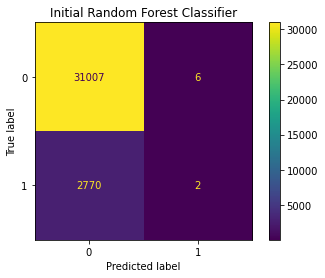

In [17]:
# Print out a nicely formatted results table
model_results(y_train, y_test, y_hat, y_pred)

# Create the confusion table
model_CM(y_test, y_pred,"Initial Random Forest Classifier")

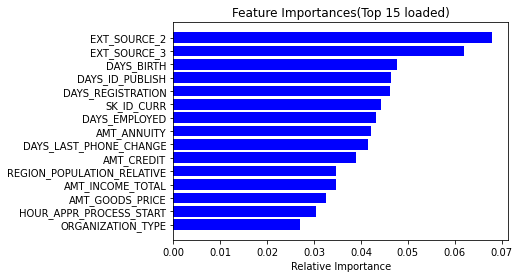

In [18]:
# Plot the features
value, y_axis = features_plot(rf, X)

# Set up x and y parameters
X,y = setXy(value, y_axis, working_df)

Part 2: Of Random Forest Classification

In [19]:
# Training and Testing with the top features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Create the final model
rf_final = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_final, y_hat, y_pred = model_fit_pred(rf_final, X_train, X_test, y_train) 

Train Accuracy;  0.9999630002367985
Test Accuracy:  0.9175965665236051
F1 Score:  0.9558313887639769


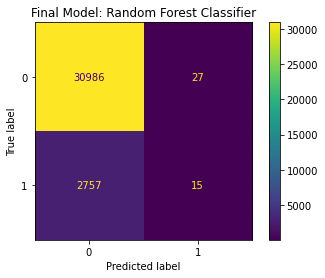

In [21]:
# Print out a nicely formatted results table
model_results(y_train, y_test, y_hat, y_pred)

# Create the confusion table
model_CM(y_test, y_pred,"Final Model: Random Forest Classifier")

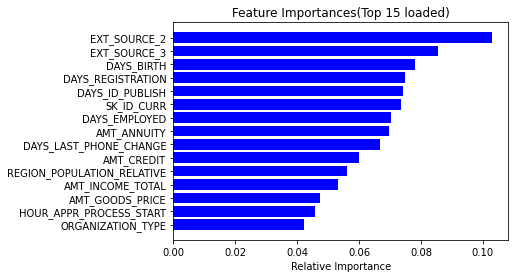

In [22]:
# Plot the features
value, y_axis = features_plot(rf_final, X)

# Set up x and y parameters
X,y = setXy(value, y_axis, working_df)

##### Gradient Boosting

In [23]:
# # Define the parameter grid for grid search
# param_grid = {'max_depth': [1,2,3,4,5]}

# # Create the gradient boosting classifier
# gbc = GradientBoostingClassifier()

# # Perform grid search
# grid_search = GridSearchCV(gbc, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

In [24]:
# Recreating the Training and Testing Set with the New Features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Create the Final GBC model
gbc_final = GradientBoostingClassifier(max_depth=3)  
gbc_final, y_hat, y_pred = model_fit_pred(gbc_final, X_train, X_test, y_train) 

Train Accuracy;  0.918896519062278
Test Accuracy:  0.9178925558679888
F1 Score:  0.9547715688559415


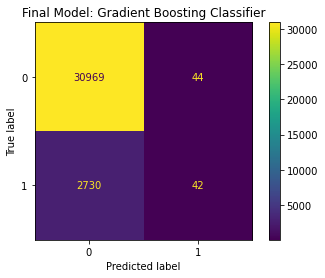

In [26]:
# Print out a nicely formatted results table
model_results(y_train, y_test, y_hat, y_pred)

# Create the confusion table
model_CM(y_test, y_pred,"Final Model: Gradient Boosting Classifier")

##### Naive Bayesian

We need to run RF again to find the best features for Naive Bayes

In [27]:
# Create the Naive Bayesian model
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf, y_hat, y_pred = model_fit_pred(rf, X_train_2, X_test_2, y_train_2) 

Train Accuracy;  1.0
Test Accuracy:  0.9983445400478244
F1 Score:  0.9983447112970977


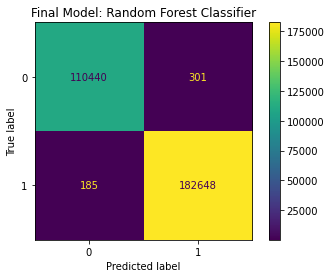

In [28]:
# Print out a nicely formatted results table
model_results(y_train_2, y_test_2, y_hat, y_pred)

# Create the confusion table
model_CM(y_test_2, y_pred,"Final Model: Random Forest Classifier")

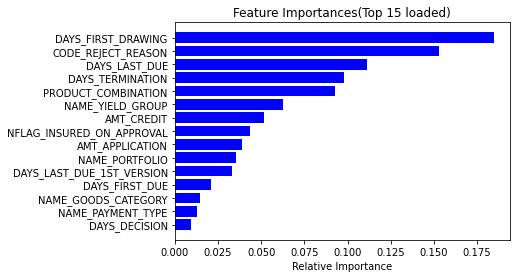

In [29]:
# Plot the features
value, y_axis = features_plot(rf,X_2)

In [30]:
# Select and show number of features
select_features = 5
features = y_axis[-select_features:]

In [31]:
# Create Bayesian Classifier
nb = GaussianNB() # Create Naive Bayes classifier object
nb, y_hat, y_pred = model_fit_pred(nb, X_train_2[features], X_test_2[features], y_train_2)

Train Accuracy;  0.9590314845030027
Test Accuracy:  0.959529794872843
F1 Score:  0.9591791295449986


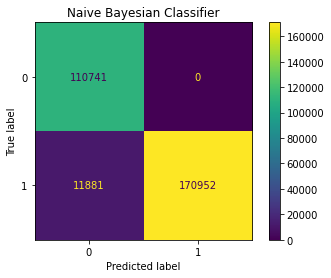

In [32]:
# Print out a nicely formatted results table
model_results(y_train_2, y_test_2, y_hat, y_pred)

# Create the confusion table
model_CM(y_test_2, y_pred,"Naive Bayesian Classifier")

##### Bayesian Results + Final Testing

In [33]:
# We are going to create some helper functions to simplify the work down

def final_test(df, features):
    # First, remove the missing values
    df = df.dropna()

    # Next, set up our X and y parameters
    X = df[features]
    y = df.TARGET

    # After, split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test

    gbc_wNB = GradientBoostingClassifier(max_depth=3)  
    gbc_wNB, y_hat, y_pred = model_fit_pred(gbc_wNB, X_train, X_test, y_train) 

    # Print out a nicely formatted results table
    model_results(y_train, y_test, y_hat, y_pred)

    # Create the confusion table
    model_CM(y_test, y_pred,"Final Model: Gradient Boosting Classifier")

In [34]:
# Combining results with the application_train data frame

# Create a copy first and create the label columns in both tables for y_hat and y_pred
table1 = X_train_2.copy()
table1['Label'] = y_hat
table2 = X_test_2.copy()
table2['Label'] = y_pred

# Create the column labels as well
col_labels = ['SK_ID_CURR', 'Label']

In [35]:
# Create the temporary data frame - first concat the two
temp_dataFrame = pd.concat([table1,table2], axis = 0)

# Then add on the column labels
temp_dataFrame = temp_dataFrame[col_labels]

# Now, merge everything into one big dataset
final_dataframe = pd.merge(df_1, temp_dataFrame, on="SK_ID_CURR")

# Clean the dataframe
X = final_dataframe.drop(columns=['TARGET', 'SK_ID_CURR'])
y = final_dataframe['TARGET']
final_dataframe = clean_all(X, y, 50)


Columns to drop with criteria of  50 %
                   col_names  perc_missing
19               OWN_CAR_AGE         66.53
38              EXT_SOURCE_1         56.51
41            APARTMENTS_AVG         50.51
42          BASEMENTAREA_AVG         58.47
44           YEARS_BUILD_AVG         66.46
45            COMMONAREA_AVG         69.83
46             ELEVATORS_AVG         53.17
47             ENTRANCES_AVG         50.14
49             FLOORSMIN_AVG         67.82
50              LANDAREA_AVG         59.35
51      LIVINGAPARTMENTS_AVG         68.36
53   NONLIVINGAPARTMENTS_AVG         69.43
54         NONLIVINGAREA_AVG         55.00
55           APARTMENTS_MODE         50.51
56         BASEMENTAREA_MODE         58.47
58          YEARS_BUILD_MODE         66.46
59           COMMONAREA_MODE         69.83
60            ELEVATORS_MODE         53.17
61            ENTRANCES_MODE         50.14
63            FLOORSMIN_MODE         67.82
64             LANDAREA_MODE         59.35
65     LIVINGAP

In [36]:
final_dataframe.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Label,TARGET
1,0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0
2,1,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,0
3,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.207691,0.306889,2.832907,0.0,0
4,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.207691,0.306889,2.832907,0.0,0
5,0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,6,...,0.0,0.0,0.0,0.0,0.0,0.207691,0.306889,2.832907,0.0,0


First we are going to test with the original labels

In [37]:
top_features = ['AMT_CREDIT','AMT_ANNUITY','DAYS_ID_PUBLISH','DAYS_BIRTH','DAYS_EMPLOYED',
                'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION','EXT_SOURCE_2',
                'EXT_SOURCE_3']

Train Accuracy;  0.9132698768197088
Test Accuracy:  0.9145685077484377
F1 Score:  0.9535247218606345


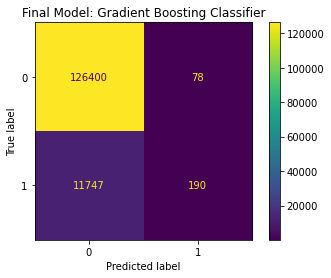

In [38]:
# Testing without any labels seeing the before and after
final_test(final_dataframe, top_features)

Train Accuracy;  0.9134161759924864
Test Accuracy:  0.9146479789040205
F1 Score:  0.9533479429441478


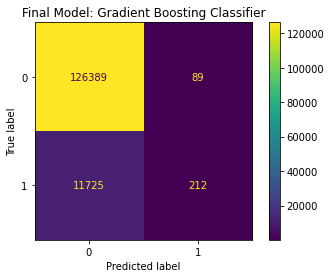

In [39]:
# Testing with created labels and seeing the before and after
top_features.append('Label')
final_test(final_dataframe, top_features)